In [1]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
%matplotlib inline

## Notes

What defines equilibrium? 
1. Thermal Equilibrium: $T_S=T_L$ at the mutual interface (LR87 eqn 4.55). They also suggest at the start of section 4.3.1. that $F\Rightarrow\infty$ is required but we don't know what $F$ is. I think its in 4.45 and is something to do with entropy. 
2. Chemical equilibrium: $\mu_S = \mu_L$. Since $T$ and $p$ are equilibrated and flow near the surface of the solid is inhibited this is governed by diffusion in the chemical BLs on their side of the interface. 
3. Phase equilibrium: $\Lambda = \infty$. At phase equilibrium the rate of formation of solid will match the rate of destruction of solid because the total free energy will be minimised. That is to say, the volume of solid and the volume of liquid will be determined by applying the leaver rule to the phase diagram. This is what Sun is giving us below. The timescale is the sum of growth and nucleation timescales. The solid fraction is fixed and this is composed of $N$ particles: How long does it take to nucleate these $N$ particles and grow them to their equilibrium size? 

<ins>(1) and (2): solid</ins>. In this case the relevant lengthscale is the particle radius $r$. Assuming (with reasonable justification) that there is no internal motion the only available dynamical timescale is that of diffusion and we can write the thermal and chemical diffusion timescales for the solid as 

$$ \tau_T^s = \frac{r^2}{\kappa_s} , \quad \tau_C^s = \frac{r^2}{D_s} , $$ 

where $\kappa_s$ is the thermal diffusivity in the solid and $D_s$ is the self-diffusion of an impurity in the solid phase. 

<ins>(1) and (2): liquid</ins>. Here the relevant lengthscales are determined by the thickness of the thermal, chemical and momentum boundary layers, $\delta_T^l$, $\delta_C^l$ and $\delta_u$ respectively. Assuming that diffusion is the dominant transfer mechanism in the boundary layer, the relevant timescales are: 

$$ \tau_T^l = \frac{\delta_T^2}{\kappa_l} , \quad \tau_C^s = \frac{\delta_C^2}{D_l} , $$ 

where the equations now use the diffusion coefficients in the liquid, subscript $l$. Since $Pr$ is probably not too far from $1$ in the core we initially assume $\delta_T \sim \delta_C$. We will also use results from Inman et al (https://www.cambridge.org/core/journals/journal-of-fluid-mechanics/article/deformation-of-ambient-chemical-gradients-by-sinking-spheres/35989F950D19A495C5FBCECED733A875),who considered an isolated sphere sinking through a chemically stable gradient. In the following $Pe = 2r U / \kappa = PrRe$ is the Peclet number where $U$ is the velocity of the sphere. Note that this is the same definition as used by Zhang and Xu (2002) below.  

There are several cases, but we can reduce these by noting that in the core the Schmidt number $Sc = \nu / D_l \gg 1$ and the Prandtl number $Pr = \nu / \kappa \sim 1$. The cases for $Sc\gg1$ are:  
a) Low $Re$ ($<10^{-2}$): 

It turns out that this case is of no relevance: see plot of $Re$ vs $r$ below. 

b) Intermediate $Re$ ($10^{-2} \le Re \le 10^2$): Inman et al (2020) eqn (3.7)

$$\frac{\delta_u}{2r} \sim 1, \quad \quad \frac{\delta_T^l}{2r} = \frac{\delta_C^l}{2r} \sim Pe^{-1/3} Sc^{-1/3}$$

c) High $Re (>200)$: See below eqn (3.5) of Inman et al (2020). 

$$\frac{\delta_u}{2r} \sim Re^{-1/2}, \quad \frac{\delta_T^l}{2r} = \quad \frac{\delta_C^l}{2r} \sim Re^{-1/2} Sc^{-1/3}$$

Note that in this case the Grossmann and Lohse (2000) theory predicts

$$ \frac{\delta_T}{2r}\sim Nu^{-1} \quad \mbox{and} \quad Nu \sim (RePr)^{1/2} \quad \mbox{if}  \quad \delta_u < \delta_T \quad \mbox{or} \quad  Nu \sim Re^{1/2}Pr^{1/3} \quad \mbox{if} \quad \delta_u > \delta_T$$

where $Nu$ is the Nusselt number. This is consistent with the Inman results. 

<ins>(3): Phase equilibrium</ins>: Equilibrium conditions give the volume fraction $V_E$ of solid that corresponds to the state where chemical potentials in the solid and liquid are equal.  However, there are an infinity of ways to partition $V_E$ between $N$ particles of radius $r$; the end-member cases are alarge number of small particles and a small number of large particles. Additional information is needed. 

Here we will assume that the inner core is build from snow leaving the base of the F-layer. The snow is assumed to fall at the Stokes velocity $V_s$. We will assume that the inner core growth rate $d r_i / dt$ is given. Then the total volume change in time $d t$ is $d V / d t = 4\pi r_i^2 (d r_i /dt)$. The volume change is the number of particles flowing to the ICB at the Stokes velocity, which is $4\pi r^2 N P V_s$, where the packing fraction $P=0.69$ for spheres. The two conditons corresponding to phase equilibrium and inner core growth are then

$$ V_E = \frac{4 \pi r^2 N}{3} , \quad 4\pi r^2 N P V_s = 4\pi r_i^2 \frac{d r_i}{dt} , \mbox{ where} \quad V_s = \frac{2}{9}\frac{\Delta \rho g r^2}{\mu}$$

The second constraint actually depends on $r^4 N$ because of the $r^2$ in $V_s$ so we can eliminate to get $r$ in terms of known quantities: 

$$ r^4 N = \frac{3 r^2 V_E}{4 \pi} = \frac{9}{2} \frac{\mu}{\Delta \rho g} \frac{r_i^2}{P} \frac{dr_i}{dt}$$

Old notes of phase equilibrium: The timescale is the time taken for a liquid to reach phase equilibrium if it was instantly transported to defined temperature where solid and liquid were in equilibrium for a given particle size. To do this we would need to:
- Calculate the volume of solid for equilibrium from the free energy curves for the solid and liquid. If impurities partition between the solid and liquid this gets numerically complicated (see my ppv/pv notebook in LEMA!) but is really just a constrained minimisation problem. If we assume impurities only go in the liquid this should be much easer. For a pure single chemical component system phase equilibrium will always be 100% solid or 100% liquid.
- Work out how many particles of radius r we need to make the volume in (1). Work out how long it takes to form this volume of solid by nucleating the required number of particles and growing them by r. This is the timescale for phase equilibrium we need for the figure. At small r we will need many particles and so the time should be dominated by nucleation. At large radius, we will need fewer particles but they will need more time to grow, so time should be dominated by growth. In either case, the first thing we need is a function to give us the time to make a number of nuclei at a given temperature. We just need to add this line to the red line we have to get the anCalculate the volume of solid for equilibrium from the free energy curves for the solid and liquid. If impurities partition between the solid and liquid this gets numerically complicated (see my ppv/pv notebook in LEMA!) but is really just a constrained minimisation problem. If we assume impurities only go in the liquid this should be much easer. For a pure single chemical component system phase equilibrium will always be 100% solid or 100% liquid.
- Work out how many particles of radius r we need to make the volume in (1). Work out how long it takes to form this volume of solid by nucleating the required number of particles and growing them swer.

<ins>(3) revisited:</ins>
In LR world it is assumed that there is a slurry, i.e. a two-phase system, that is initially out of equilbrium. The question is: how long does it that this system to reach equilibrium. In this case the nucleation TS is irrelevant and only growth matters. Then the calculation is simply the Sun calculation. 

LR87: On pg 69 (bottom) they argue that "it would be more consistent to suppose that thermal and phase equilibrium proceed at a similar rate - see 3.2.2.". 

## Some papers of minor relevance: 

Janudom, S., Wannasin, J., Basem, J. and Wisutmethangoon, S., 2013. Characterization of flow behavior of semi-solid slurries containing low solid fractions in high-pressure die casting. Acta materialia, 61(16), pp.6267-6275.
- "In literature, all the studies of semi-solid metal die filling were conducted with high initial solid fractions in the range of 30–60% [1,5,6]...For semi-solid slurry with low initial solid fractions of less than 15%, however, no studies have been reported. With these very low initial solid fractions, the flow behavior of semi-solid slurries is quite complicated. The initial solid fraction starts from a very low fraction in the range of 3–15% when it is poured into a shot sleeve. The solid fraction then abruptly increases to a higher value in the shot sleeve and then in the die."
- They realise solid fractions as low as 3% in experiements and do simple characterisation of the flow, but no detailed analysis or comparison with theory.  

Chen, J.Y. and Fan, Z., 2002. Modelling of rheological behaviour of semisolid metal slurries Part 1–Theory. Materials Science and Technology, 18(3), pp.237-242.
- Says that "liquid-like"slurries are generally referred to as semi-solid metal slurries. 
- Could ultimately be interesting. They develop a micro-scale rheological model based on agglomeration. 
- However, as far as I could tell, there is no melting/freezing. 

In [2]:
# Define parameters
secinyr = 60.0*60.0*24.0*365.0
k     = 250.0                    # thermal conductivity of solid iron 
rhos  = 12700                    # solid density
rhol  = 12100                    # liquid density
cp    = 750                      # specific heat
kappa = k/(rhol*cp)              # thermal diffusivity of liquid
Dliq  = 1e-9                     # self-diffusion of O in liquid
Dsol  = 1e-12                    # self-diffusion of O in solid
mu    = 1e-6                     # kinematic viscosity
drho  = rhos-rhol                # density difference
g     = 3.7                      # gravity at ICB from PREM
Vic      = 4 * np.pi * 1221000.0**3 / 3.0  # IC volume
kb       = 1.380648e-23          # Boltzmann constant
secingyr = 3.1536e+16      
ri =1221e3

print("Pr = ", mu / kappa)

r = np.logspace(-6,0,num=20)     # Array of particle sizes in metres

Pr =  0.0363


In [3]:
# Calculate diffusion and freefall timescales
tt = np.zeros(len(r))  # Thermal diffusion time
ts = np.zeros(len(r))  # Chemical diffusion in solid
tl = np.zeros(len(r))  # Chemical diffusion in liquid
tVl= np.zeros(len(r))  # Timescale based on Stokes velocity Vs

# All timescales in yrs
j = 0
for i in r:    
    tt[j] = i**2/kappa/secinyr
    ts[j] = i**2/Dsol/secinyr
    tl[j] = i**2/Dliq/secinyr
    
    Vs    = 2.0 * drho * g * i**2 / (9.0 * mu * rhol)
    tVl[j]= 100e3/Vs/secinyr
    
    #print("{:e}".format(i), "{:e}".format(tt), "{:e}".format(ts), "{:e}".format(tl))
    j = j + 1

## Falling timescale of slurry patricles. 

A key question is whether patricles of a given radius $r$ will fall out of the slurry before they can equilibrate with their surroundings via diffusion. The simplest estimate is based on Stokes flow, which gives the terminal velocity of the partickle by balancing buoyancy and drag forces and applies at low Reynolds number $Re$. Zhang and Xu (2003, https://www.sciencedirect.com/science/article/pii/S0012821X03002978?casa_token=sjZhMFVPcuMAAAAA:89Txq8oZeXVy3-pyY7nqj942kzd95iOZKYyELUrlthZ-nM7vzabhz-F8trUMdFLXnim9N6A2Jkg) summarise and extend previous results to high $Re$ and so we consider both cases. 

The classical Stokes flow velocity is given by

$$ V_S = \frac{2}{9} \frac{\Delta \rho g a^2}{\mu} $$

while the Zhang and Xu equation (20) gives

$$ V_Z = \sqrt{\left( \frac{8}{3} \frac{\Delta \rho g a}{\rho_l C_D} \right) }$$

The drag coefficient $C_D$ is 

$$ C_D = \frac{2F_D}{\rho_l V^2 A} V$$

If $F_D = 6\pi \mu a$ as given by Stokes drag then we can take $V=V_z$ in the equation for $C_D$, which becomes $C_D = (12 \pi \mu a) / (\rho_l V_Z A)$. Subbing into the original eqn for $V_Z$ and noting that the area $A\sim\pi a^2$ we recover the Stokes velocity.

As $Re$ increases the drag coefficient increases and so $V_Z$ tends to decrease compared to $V_S$. Hence the falling time should be greater for the high $Re$ case than the low $Re$ case at high $Re$. This provides a check on the results below. 

In [4]:
# For given velocity outputs the Reynolds number Re and drag coefficient Cd. 
# Used to check fzhang_opt: if fzhang_opt has found the velocity that solves the equations
# then input u = output u

def fzhang(u,r):
    """
    r  = particle radius
    u  = initial velocity guess
    mu = kinematic viscosity
    Re = Reynolds number
    Cd = drag coefficient
    g  = gravity at ICB
    drho = solid-liquid density difference
    rhol = liquid density
    """
    
    Re  = np.abs(2*r * u / mu)                                              # Eqn 1  of ZX02
    Cd  = (24.0/Re) * (1.0 + 0.15*Re**0.687) + 0.42/(1.0 + 42500*Re**-1.16) # Eqn 19 of ZX02
    unum= 8.0 * g * r * drho                                                # Eqn 20 of ZX02
    uden= 3.0 * rhol * Cd                                                   # Eqn 20 of ZX02
    u   = np.sqrt(unum/uden)
    return Re, Cd, u

In [5]:
# Finds the velocity, "result", based on an initial guess u using the eqns in Zhang and Xu (2003)

def fzhang_opt(u,rad):
    """
    rad= particle radius
    u  = initial velocity guess
    mu = kinematic viscosity
    Re = Reynolds number
    g  = gravity at ICB
    drho = solid-liquid density difference
    rhol = liquid density
    """
    
    re = np.abs(2*rad*u/mu)

    result = (8.0 * g * rad * drho) / (3.0 * rhol * 
          ( (24.0/re ) * (1.0 + 0.15*re**0.687) + 
                                    0.42/(1.0 + 42500*re**-1.16) ) )
    result = np.sqrt(result)
    result = result - u

    return result

In [6]:
# Obtain the timescales that depend on the flow velocity: 
# 1. The Stokes flow timescale, tVh
# 2. Thermal  diffusion in the liquid, tt_liq, based on the BL thickness. 
# 3. Chemical diffusion in the liquid, tl_liq, based on the BL thickness. 

tVh  = np.zeros(len(r))
Pe   = np.zeros(len(r))
delta= np.zeros(len(r))
tt_liq = np.zeros(len(r))  # Thermal diffusion time
tl_liq = np.zeros(len(r))  # Chemical diffusion in liquid

j = 0
for i in r:
    rad        = np.float(i)
    Vs         = optimize.brentq(fzhang_opt, -1.0, 100.0, args=(rad))
    Re, Cd, uX = fzhang(Vs,rad)
    Pe[j]      = Re * mu / kappa
    
    if Re < 100:     # Intermediate Re case
        delta[j]   = Pe[j]**(-0.33333) * (mu/Dliq)**(-0.33333) * 2*i
    if Re > 100:     # High Re case
        delta[j]   = Pe[j]**(-0.5)     * (mu/Dliq)**(-0.33333) * 2*i
        
    tt_liq[j] = delta[j]**2/kappa/secinyr
    tl_liq[j] = delta[j]**2/Dliq/secinyr

    #print(np.round(Re,9), np.round(Cd,5), np.round(uX,9), np.round(Vs,9))
    tVh[j] = 100e3/Vs/secinyr
    j = j + 1

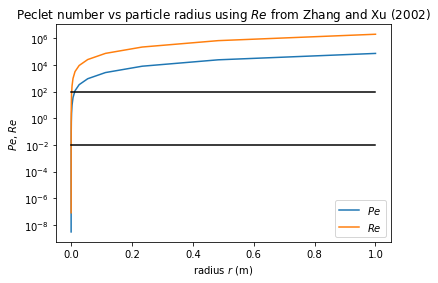

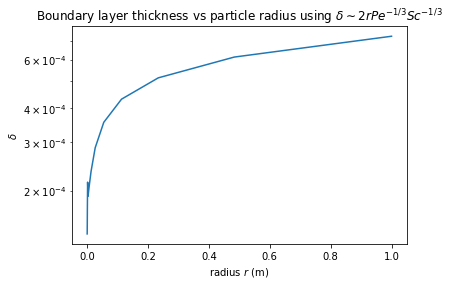

In [7]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.plot(r, Pe         , label="$Pe$")
ax.plot(r, Pe*kappa/mu, label="$Re$")
ax.plot(r, 1e-2*np.ones(len(r)), color="black")
ax.plot(r, 1e2 *np.ones(len(r)), color="black")
ax.set_xlabel('radius $r$ (m)')
ax.set_ylabel('$Pe$, $Re$')
ax.legend(loc=4)
ax.set_title('Peclet number vs particle radius using $Re$ from Zhang and Xu (2002)')
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.plot(r, delta)
ax.set_xlabel('radius $r$ (m)')
ax.set_ylabel('$\delta$')
ax.set_title('Boundary layer thickness vs particle radius using $\delta \sim 2r Pe^{-1/3} Sc^{-1/3}$')
plt.show()


# Crystal growth following Sun et al. (2018)

The Kirkpatrick growth models assume that the process of crystal growth at an interface can be described
in terms of a diffusional equation and treated as if this was solving a bulk diffusion problem (i.e. that
the Stokes-Einstien equation holds). This seems unlikly. Fortunatly, more recent work has 
attempted to quantify and understand crystal growth in metals using atomic scale simulation. Importantly,
this is a very quick process.

Here we follow Sun et al. (2018; Nature Materials 17:881-886, https://doi.org/10.1038/s41563-018-0174-6)
who simulate crystal growth of the FCC metals Al, Ni, Cu, Ag, Pt and Pb using an embedded atom model at
temperatures from the (simulated) melting point down to undercoolings of ~300 K below the melting point in order
to understand why crystal growth for these crystals was "ultrafast". These calculations were undertaken
using LAMMPS and were not at elevated pressure. These atomic scale results were compared with three models
and an emprical fit:

1. A linear fit of growth rate againts undercooling
2. The Wilson–Frenkel model, where growth is limited by diffusion in the liquid
3. A Ginzburg–Landau approach, where growth is contolled by density fluctuations in the liquid
4. A collision rate model

All these models can be described the interaction of a kinetic and a thermodynamic term (equation 1 of Sun; S1):

$$ V(T) = k(T) \left[1 - \exp\left(\frac{\Delta\mu}{k_B T}\right)  \right],$$

where $V(T)$ is the growth rate of the crystal (normal to the 111 face) $k(T)$ is a kinetic function and
$\Delta\mu$ is the difference in the chemical potential of the solid and theliquid. This is analogous to K4,
(or K8). $k(T)$ is different for the different models:

1. $k(T) = k_0$
2. $k(T) = l\frac{6D(T)}{\gamma^2}$
3. $k(T) \propto \frac{S(K_i)}{\tau(K_i)}$
3. $k(T) \propto \sqrt{\frac{3K_B T}{M}}$

Models 1 and 4 reproduce the atomic scale data fairly well over the temperature range (see Sun et al. Fig 1).

For simplicity, I'll take model 1 and write a growth rate function.

Sun SI: https://static-content.springer.com/esm/art%3A10.1038%2Fs41563-018-0174-6/MediaObjects/41563_2018_174_MOESM1_ESM.pdf

707.5073794266233


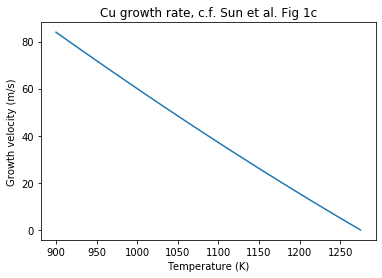

In [8]:
# Data for Cu (because I have a EAM set up in LAMMPS for Cu in case we want to take it further)

kB = 1.380649e-23 # J/K
cu_k0 = 212 # [K^-1]? Table 2
cu_tm = 1275 # [K] Table 1
cu_dhm = 1.21 * kB * cu_tm # [J] SI table S1, heat of fusion at melting point

cu_mass = 1.055e-25
cu_k04  =np.sqrt(3.0*kb*cu_tm/cu_mass)
print(cu_k04)

def sun_velocity_fit(dt, tm, dhm, k0):
    """
    dT is the undercooling
    Tm is the melting temperature
    dmu is the difference in chemical potentials
    k0 is a rate constant
    r is the particle radius
    """
    t = tm - dt
    d_mu = (tm - t) * (dhm / tm) # K13 / first para of Sun SI
    kB = 1.380649e-23 #J/K
    v = k0 * (1.0 - np.exp(-d_mu/(kB * t)))
    return v

# Plot graph - like Fig 1 of paper
fig, ax = plt.subplots()
ts_ = np.linspace(900, cu_tm)
dts = cu_tm - ts_
vs  = sun_velocity_fit(dts, cu_tm, cu_dhm, cu_k0)
ax.plot(ts_, vs)
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Growth velocity (m/s)')
ax.set_title('Cu growth rate, c.f. Sun et al. Fig 1c')
plt.show()

dT     = 200.0
tIsun     = np.zeros(len(r))

j = 0
for i in r:
    G = sun_velocity_fit(dT, cu_tm, cu_dhm, cu_k0)
    tIsun[j] = i/G/secinyr
    j = j + 1

## Nucleation timescale

Uses eqn 6 of https://www.sciencedirect.com/science/article/pii/S0012821X18306782

In [9]:
def tauv(dT, Tm):
    """
    hf    = enthalpy of fusion
    gamma = surface tension
    hc    = enthalpy correction - see DPA19, below eqn 2
    """
    hf    = 0.976e10
    gamma = 1.05
    prefac= 5.366215575895298e-46   # Other way up to Huguet
    
    hc   = 1.0 - 7.046e-5*dT
    T_Fe = dT + Tm
    num  = 16 * np.pi * Tm**2 * gamma**3
    den  = 3  * kb * hf**2 * hc**2 * T_Fe * dT**2
    fac  = num/den
    return prefac * np.exp(fac) 

In [10]:
Vic = 4.0*np.pi*1221000**3 / 3.0

tnuc1 = tauv(700, 5600) / Vic / secinyr
print(tnuc1)

2.1963624974819873


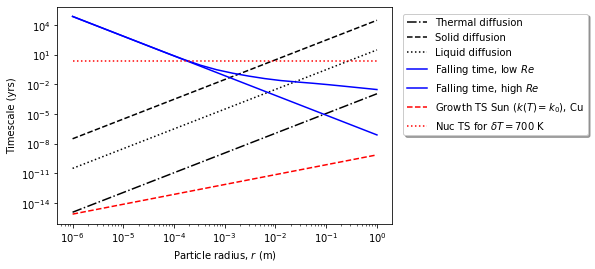

In [11]:
plt.xlabel("Particle radius, $r$ (m)")
plt.ylabel("Timescale (yrs)")
plt.loglog(r, tt , color="black", linestyle="dashdot", label="Thermal diffusion")
plt.loglog(r, ts , color="black", linestyle="--"     , label="Solid diffusion")
plt.loglog(r, tl , color="black", linestyle=":"      , label="Liquid diffusion")
plt.loglog(r, tVl, color="blue" , linestyle="-"      , label="Falling time, low $Re$")
plt.loglog(r, tVh, color="blue" , linestyle="-"      , label="Falling time, high $Re$")
plt.loglog(r, tIsun , color="red" , linestyle="--", label="Growth TS Sun ($k(T) =  k_0$), Cu")
plt.loglog(r, tnuc1*np.ones(len(r)) , color="red" , linestyle=":", label="Nuc TS for $\delta T = 700$ K")
plt.legend(loc='upper right', bbox_to_anchor=(1.6, 0.99),
          fancybox=True, shadow=True)

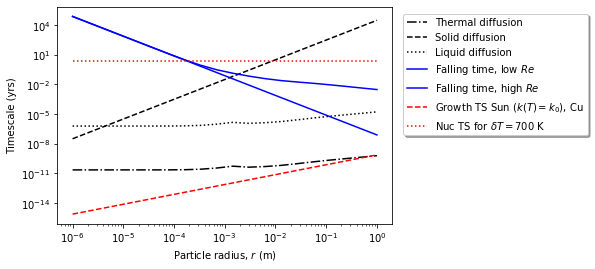

In [12]:


plt.xlabel("Particle radius, $r$ (m)")
plt.ylabel("Timescale (yrs)")
plt.loglog(r, tt_liq, color="black", linestyle="dashdot",label="Thermal diffusion")
plt.loglog(r, ts    , color="black", linestyle="--"     , label="Solid diffusion")
plt.loglog(r, tl_liq, color="black", linestyle=":"      , label="Liquid diffusion")
plt.loglog(r, tVl   , color="blue" , linestyle="-"      , label="Falling time, low $Re$")
plt.loglog(r, tVh   , color="blue" , linestyle="-"      , label="Falling time, high $Re$")
plt.loglog(r, tIsun , color="red"  , linestyle="--"     , label="Growth TS Sun ($k(T) =  k_0$), Cu")
plt.loglog(r, tnuc1*np.ones(len(r)), color="red"        , linestyle=":", label="Nuc TS for $\delta T = 700$ K")

plt.legend(loc='upper right', bbox_to_anchor=(1.6, 0.99),
          fancybox=True, shadow=True)

## Conclusions from these graphs: 
We are assuming that the particles remain the same radius as they fall through the F-layer. 

We also assume that the system hsa overcome the initial homogeneous nucletaion barrier. 

1. If solid diffusion is relevant it is always the limiting process.
2. If solid diffusion is not relevant and the BL plot is relevant then the system is basically always in phase equilibrium.
3. If the particle radius changes as it moves through the F-layer this will not change the fact that solid diffusion is slower than liquid or thermal diffusion. 

$$ V_E = \frac{4 \pi r^2 N}{3} , \quad 4\pi r^2 N P V_s = 4\pi r_i^2 \frac{d r_i}{dt} , \mbox{ where} \quad V_s = \frac{2}{9}\frac{\Delta \rho g r^2}{\mu}$$

The second constraint actually depends on $r^4 N$ because of the $r^2$ in $V_s$ so we can eliminate to get $r$ in terms of known quantities: 

$$ r^4 N = \frac{3 r^2 V_E}{4 \pi} = \frac{9}{2} \frac{\mu}{\Delta \rho g} \frac{r_i^2}{P} \frac{dr_i}{dt}$$

In [13]:
dridt = 1e-3 / secinyr
Vslurry = 4 * np.pi * ((ri+200e3)**3 - ri**3) /3.0
print(4*np.pi *ri**2 * dridt,Vslurry)
Ve    = 0.1 * Vslurry
Pack  = 0.67
r2    = 6.0 * np.pi * (mu * rhol) * ri**2 * dridt / (Ve * drho * g* Pack) 
N     = 3.0 * Ve / (4 * np.pi * r2) 
print(np.sqrt(r2), N)

#optimize.brentq(rubie2, 0.00001, 100, args=(MFe, MO, MSi, MFeO, MSiO2, MMgO))


594.0658464320727 4.3941439690599613e+18
1.2844126600254804e-10 6.358819793960477e+36


## Interface timescale. 

Here I implement equation 17 of Kirkpatrick (1974), "Kirkpatrick, R.J., 1975. Crystal growth from the melt: a review. American Mineralogist: Journal of Earth and Planetary Materials, 60(9-10), pp.798-814.". Below I refer to his equations as KX. 

- I assume that the growth rate is $da/dt$ where $a$ is particle radius
- Then time is $a/(da/dt)$
- I interpret this as the timescale required to grow the crystal to size a assuming that there are no diffusive hiderances to the process; the only obstacle seems to be the random detachment of particles from the surface according to K4.

- I take $f=1$
- Dario validates that K13 is a pretty good approximation; I have not included the correction in our eqn 2 here. 

The aassumption in K16 is checked in the cell kirk_growth17: it seems to be a bad approximation. Therefore we use eqn 14 in cell kirk_growth14. 

**However**

This model was found to be unsuitable because of the assumption that the rate constant can be described by a diffusion process (see eqn 9, which follows Turnbull and Cohen, 1960). It was replaced by the Sun et al study above. 

In [14]:
# Implement growth model of Kirkpatrick eqn 14, which does not invoke approximation K16
# Hc is latent heat
# Tl is liquidus
# eta is dynamic viscosity in Pa.s
def kirk_growth14(dT,Tl,eta,r):
    T = Tl - dT
    kB = 1.380649e-23 #J/K
    Rg = 8.314462
    f  = 1
    hf = 0.976e10
    Y  = (f*kB*T) / (3.0*np.pi*r**2*eta) * ( 1.0-np.exp( -(hf * dT)/(Rg*T*Tl) ) )
    return Y

In [15]:
# Implement growth model of Kirkpatrick eqn 17
# Hc is latent heat
# Tl is liquidus
# eta is dynamic viscosity in Pa.s
def kirk_growth17(dT,Tl,eta,r):
    kB = 1.380649e-23 #J/K
    Rg = 8.314462
    f  = 1
    hf = 0.976e10
    Y  = (f * kB) / (3.0 * np.pi * r**2 * eta) * (hf * dT) / (Rg * Tl)
    return Y

In [16]:
hf = 0.976e10 # From Dario
dT = 1.0      # 1 K undercooling
Tl = 6500.0   # Melting T of pure iron, high value
Tm_FeO = 5600.0
dT     = 200.0
tI     = np.zeros(len(r))

j = 0
for i in r:
    G = kirk_growth14(dT,Tm_FeO,0.01,i)
    tI[j] = i/G/secinyr
    j = j + 1

# 